# Spider-Man

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [2]:
# download modsim.py if necessary

from os.path import exists

filename = 'modsim.py'
if not exists(filename):
    from urllib.request import urlretrieve
    url = 'https://raw.githubusercontent.com/AllenDowney/ModSim/main/'
    local, _ = urlretrieve(url+filename, filename)
    print('Downloaded ' + local)

In [3]:
# import functions from modsim

from modsim import *

In this case study we'll develop a model of Spider-Man swinging from a springy cable of webbing attached to the top of the Empire State Building.  Initially, Spider-Man is at the top of a nearby building, as shown in this diagram.

![Diagram of the initial state for the Spider-Man case
study.](https://github.com/AllenDowney/ModSim/raw/main/figs/spiderman.png)

The origin, `O⃗`, is at the base of the Empire State Building.  The vector `H⃗` represents the position where the webbing is attached to the building, relative to `O⃗`.  The vector `P⃗` is the position of Spider-Man relative to `O⃗`.  And `L⃗` is the vector from the attachment point to Spider-Man.

By following the arrows from `O⃗`, along `H⃗`, and along `L⃗`, we can see that 

`H⃗ + L⃗ = P⃗`

So we can compute `L⃗` like this:

`L⃗ = P⃗ - H⃗`

The goals of this case study are:

1. Implement a model of this scenario to predict Spider-Man's trajectory.

2. Choose the right time for Spider-Man to let go of the webbing in order to maximize the distance he travels before landing.

3. Choose the best angle for Spider-Man to jump off the building, and let go of the webbing, to maximize range.

I'll create a `Params` object to contain the quantities we'll need:

1. According to [the Spider-Man Wiki](http://spiderman.wikia.com/wiki/Peter_Parker_%28Earth-616%29), Spider-Man weighs 76 kg.

2. Let's assume his terminal velocity is 60 m/s.

3. The length of the web is 100 m.

4. The initial angle of the web is 45 degrees to the left of straight down.

5. The spring constant of the web is 40 N / m when the cord is stretched, and 0 when it's compressed.

Here's a `Params` object with the parameters of the system.

In [4]:
params = Params(height = 381,    # m,
                g = 9.8,         # m/s**2,
                mass = 75,       # kg,
                area = 1,        # m**2,
                rho = 1.2,       # kg/m**3,
                v_term = 60,     # m / s,
                length = 100,          # m,
                angle = (270 - 45),    # degree,
                k = 40,                # N / m,
                t_0 = 0,               # s,
                t_end = 30,            # s
               )

Compute the initial position

In [5]:
def initial_condition(params):
    """Compute the initial position and velocity.
    
    params: Params object
    """
    H⃗ = Vector(0, params.height)
    theta = np.deg2rad(params.angle)
    x, y = pol2cart(theta, params.length)
    L⃗ = Vector(x, y)
    P⃗ = H⃗ + L⃗
    V⃗ = Vector(0, 0)
    
    return State(x=P⃗.x, y=P⃗.y, vx=V⃗.x, vy=V⃗.y)

In [6]:
initial_condition(params)

x     -70.710678
y     310.289322
vx      0.000000
vy      0.000000
Name: state, dtype: float64

Now here's a version of `make_system` that takes a `Params` object as a parameter.

`make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.

In [7]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    init = initial_condition(params)
    
    mass, g = params.mass, params.g
    rho, area, v_term = params.rho, params.area, params.v_term
    C_d = 2 * mass * g / (rho * area * v_term**2)
    
    return System(params, init=init, C_d=C_d)

Let's make a `System`

In [8]:
system = make_system(params)

In [9]:
system.init

x     -70.710678
y     310.289322
vx      0.000000
vy      0.000000
Name: state, dtype: float64

### Drag and spring forces

Here's drag force, as we saw in Chapter 22.

In [10]:
def drag_force(V⃗, system):
    """Compute drag force.
    
    V⃗: velocity Vector
    system: `System` object
    
    returns: force Vector
    """
    rho, C_d, area = system.rho, system.C_d, system.area
    
    mag = rho * vector_mag(V⃗)**2 * C_d * area / 2
    direction = -vector_hat(V⃗)
    f_drag = direction * mag
    return f_drag

In [11]:
V⃗_test = Vector(10, 10)

In [12]:
drag_force(V⃗_test, system)

x   -28.873527
y   -28.873527
dtype: float64

And here's the 2-D version of spring force.  We saw the 1-D version in Chapter 21.

In [13]:
def spring_force(L⃗, system):
    """Compute drag force.
    
    L⃗: Vector representing the webbing
    system: System object
    
    returns: force Vector
    """
    extension = vector_mag(L⃗) - system.length
    if extension < 0:
        mag = 0
    else:
        mag = system.k * extension
        
    direction = -vector_hat(L⃗)
    f_spring = direction * mag
    return f_spring

In [14]:
L⃗_test = Vector(0, -system.length-1)

In [15]:
f_spring = spring_force(L⃗_test, system)
f_spring

x    -0.0
y    40.0
dtype: float64

Here's the slope function, including acceleration due to gravity, drag, and the spring force of the webbing.

In [16]:
def slope_func(t, state, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    P⃗ = Vector(x, y)
    V⃗ = Vector(vx, vy)
    g, mass = system.g, system.mass
    
    H⃗ = Vector(0, system.height)
    L⃗ = P⃗ - H⃗
    
    a_grav = Vector(0, -g)
    a_spring = spring_force(L⃗, system) / mass
    a_drag = drag_force(V⃗, system) / mass
    
    A⃗ = a_grav + a_drag + a_spring
    
    return V⃗.x, V⃗.y, A⃗.x, A⃗.y

As always, let's test the slope function with the initial conditions.

In [17]:
slope_func(0, system.init, system)

(0.0, 0.0, 5.359248925640619e-15, -9.799999999999995)

And then run the simulation.

In [18]:
results, details = run_solve_ivp(system, slope_func)
details.message

'The solver successfully reached the end of the integration interval.'

### Visualizing the results

We can extract the x and y components as `Series` objects.

The simplest way to visualize the results is to plot x and y as functions of time.

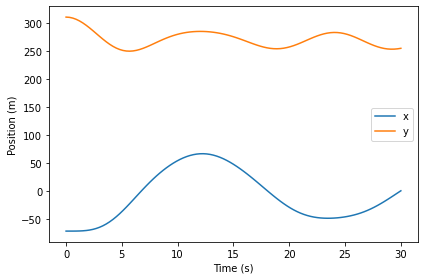

In [19]:
def plot_position(results):
    results.x.plot(label='x')
    results.y.plot(label='y')

    decorate(xlabel='Time (s)',
             ylabel='Position (m)')
    
plot_position(results)

We can plot the velocities the same way.

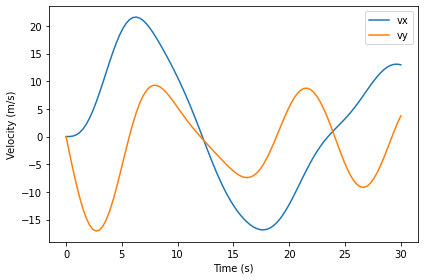

In [20]:
def plot_velocity(results):
    results.vx.plot(label='vx')
    results.vy.plot(label='vy')

    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/s)')
    
plot_velocity(results)

Another way to visualize the results is to plot y versus x.  The result is the trajectory through the plane of motion.

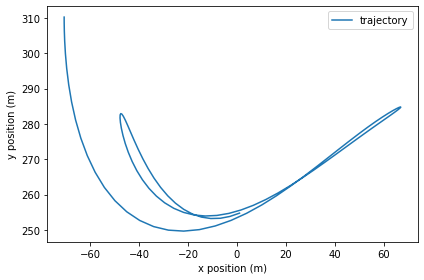

In [31]:
def plot_trajectory(results, label):
    x = results.x
    y = results.y
    make_series(x, y).plot(label=label)

    decorate(xlabel='x position (m)',
             ylabel='y position (m)')
    
plot_trajectory(results, label='trajectory')

## Letting go

Now let's find the optimal time for Spider-Man to let go.  We have to run the simulation in two phases because the spring force changes abruptly when Spider-Man lets go, so we can't integrate through it.

Here are the parameters for Phase 1, running for 9 seconds.

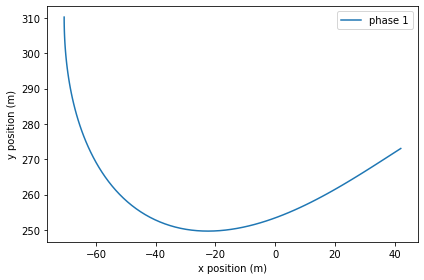

In [33]:
params1 = params.set(t_end=9)
system1 = make_system(params1)
results1, details1 = run_solve_ivp(system1, slope_func)
plot_trajectory(results1, label='phase 1')

The final conditions from Phase 1 are the initial conditions for Phase 2.

In [34]:
t_0 = results1.index[-1]
t_0

9.0

In [35]:
init = results1.iloc[-1]
init

x      42.091085
y     273.046794
vx     14.631838
vy      7.940821
Name: 9.0, dtype: float64

In [36]:
t_end = t_0 + 10

Here is the `System` for Phase 2.  We can turn off the spring force by setting `k=0`, so we don't have to write a new slope function.

In [37]:
system2 = system1.set(init=init, t_0=t_0, t_end=t_end, k=0)

Here's an event function that stops the simulation when Spider-Man reaches the ground.

In [38]:
def event_func(t, state, system):
    """Stops when y=0.
    
    state: State object
    t: time
    system: System object
    
    returns: height
    """
    x, y, vx, vy = state
    return y

Run Phase 2.

In [39]:
results2, details2 = run_solve_ivp(system2, slope_func, 
                                   events=event_func)
details2.message

'A termination event occurred.'

Plot the results.

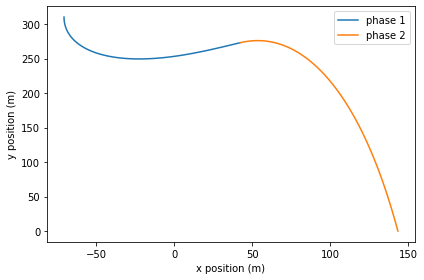

In [40]:
plot_trajectory(results1, label='phase 1')
plot_trajectory(results2, label='phase 2')

Now we can gather all that into a function that takes `t_release` and `V_0`, runs both phases, and returns the results.

In [41]:
def run_two_phase(t_release, params):
    """Run both phases.
    
    t_release: time when Spider-Man lets go of the webbing
    """
    params1 = params.set(t_end=t_release)
    system1 = make_system(params1)
    results1, details1 = run_solve_ivp(system1, slope_func)

    t_0 = results1.index[-1]
    t_end = t_0 + 10
    init = results1.iloc[-1]

    system2 = system1.set(init=init, t_0=t_0, t_end=t_end, k=0)
    results2, details2 = run_solve_ivp(system2, slope_func, 
                                       events=event_func)

    return results1.append(results2)

And here's a test run.

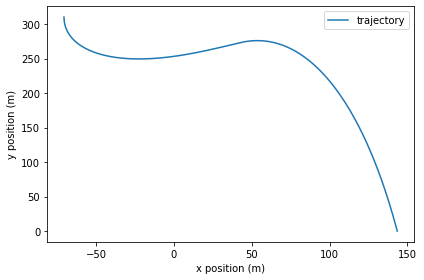

In [44]:
t_release = 9 
results = run_two_phase(t_release, params)
plot_trajectory(results, 'trajectory')

In [45]:
x_final = results.iloc[-1].x
x_final

143.4532612857731

### Animation

Here's a draw function we can use to animate the results.

In [46]:
from matplotlib.pyplot import plot

xlim = results.x.min(), results.x.max()
ylim = results.y.min(), results.y.max()

def draw_func(t, state):
    plot(state.x, state.y, 'bo')
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             xlim=xlim,
             ylim=ylim)

In [47]:
# animate(results, draw_func)

## Maximizing range

To find the best value of `t_release`, we need a function that takes possible values, runs the simulation, and returns the range.

In [48]:
def range_func(t_release, params):
    """Compute the final value of x.
    
    t_release: time to release web
    params: Params object
    """
    results = run_two_phase(t_release, params)
    x_final = results.iloc[-1].x
    print(t_release, x_final)
    return x_final

We can test it.

In [49]:
range_func(9, params)

9 143.4532612857731


143.4532612857731

And run it for a few values.

In [50]:
for t_release in linrange(3, 15, 3):
    range_func(t_release, params)

3.0 -22.68561248350303
6.0 116.16347621213171
9.0 143.4532612857731
12.0 74.48343530178806
15.0 -25.12792299944463


Now we can use `maximize_scalar` to find the optimum.

In [51]:
bounds = [6, 12]
res = maximize_scalar(range_func, params, bounds=bounds)

6 116.16347621213171
8.29179606750063 148.84107154375528
9.70820393249937 133.74491737619695
7.416407864998738 147.3897253095032
8.008359567724618 149.51746989063128
7.975434217382093 149.53160159029417
7.957208869935015 149.53331435198066
7.959151805862069 149.53334087177967
7.9592128194323415 149.53334089410737
7.959209368044804 149.53334089416063
7.959205916657318 149.5333408940567


Finally, we can run the simulation with the optimal value.

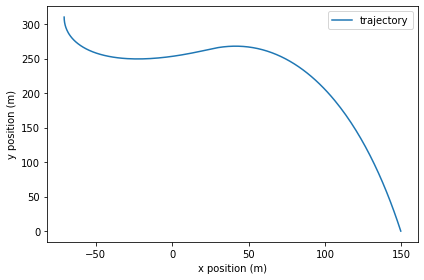

In [53]:
best_time = res.x
results = run_two_phase(best_time, params)
plot_trajectory(results, label='trajectory')

In [54]:
x_final = results.iloc[-1].x
x_final

149.53334089416063